# Explore how to improve track reconstruction performance

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml
import logging

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
# import seaborn as sns
from tqdm import tqdm
# import torch_geometric
from scipy import sparse as sps

# import seaborn as sns
import torch
import warnings

warnings.filterwarnings("ignore")
sys.path.append("../../..")

from notebooks.ITk.utils import *
from onetrack import TrackingData
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.basicConfig(level=logging.INFO)

/global/homes/d/danieltm/.conda/envs/exatrkx-cori/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Implementation

In [2]:
# Read yaml config 
with open("tracking_config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [3]:
# Load in files
files = list_files(os.path.join(config["graph_input_dir"], "train"))[:2]

In [4]:
sample = torch.load(files[0], map_location="cpu")

In [4]:
# Build TrackingData object
tracking_data = TrackingData(files)

INFO:root:Loading files
100%|██████████| 2/2 [00:00<00:00,  6.60it/s]
INFO:root:Building events
100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


## Example usage

Sanity check the graph:

In [16]:
tracking_data.build_candidates(building_method="CC", sanity_check=True)

INFO:root:Building candidates with sanity check: True
100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


In [17]:
tracking_data.evaluate_candidates(evaluation_method="matching")

INFO:root:Evaluating candidates
100%|██████████| 100/100 [00:34<00:00,  2.90it/s]


{'building_method': 'CC', 'evaluation_method': 'matching', 'eff': 0.9780958478141577, 'single_eff': 0.9782970550576184, 'fr': 0.00010465893263988946, 'dup': 0.13891460636165295}
n_true_tracks: 109340, n_reco_tracks: 124213, n_matched_particles: 106945, n_matched_tracks: 124200, n_duplicated_tracks: 17255


Now run real pipeline:

In [9]:
tracking_data.build_candidates(building_method="CC", score_cut = 0.85)

INFO:root:Building candidates with sanity check: False
100%|██████████| 10/10 [00:00<00:00, 45.28it/s]


## Clean

### Roadmap

1. Create track candidates with connected components
2. Construct all paths from track candidates that are greater than a certain length


In [26]:
edges = tracking_data[0].graph.edges
hits = tracking_data[0].graph.hits
score_cut = 0.85
edge_mask = edges["scores"] > score_cut

In [27]:
# Order edges by increasing R
r, phi, z = hits["x"].T
R = np.sqrt(r**2 + z**2)

# in_edges are the nodes towards the inner of the detector, out_edges are the nodes towards the outer
in_edges, out_edges = edges["edge_index"][:, edge_mask]

# Ensure edges are numpy arrays
if (type(in_edges) != np.ndarray) or (type(out_edges) != np.ndarray):
    in_edges = in_edges.numpy()
    out_edges = out_edges.numpy()

# Sort edges by increasing R
wrong_direction_mask = R[in_edges] > R[out_edges]
in_edges[wrong_direction_mask], out_edges[wrong_direction_mask] = out_edges[wrong_direction_mask], in_edges[wrong_direction_mask]

In [28]:
starting_nodes = np.unique(in_edges[~np.isin(in_edges, out_edges)])
ending_nodes = np.unique(out_edges[~np.isin(out_edges, in_edges)])

In [29]:
import networkx as nx

### Develop

In [7]:
import cugraph as cg

In [8]:
min_length = 5

In [55]:
from tqdm.contrib.concurrent import process_map

In [21]:
edge_attr = np.ones(row.size(0))

N = hits["x"].size(0)
sparse_edges = sps.coo_matrix((edge_attr, (row.numpy(), col.numpy())), (N, N))

In [22]:
inverse_map = torch.zeros(starting_nodes.max()+1, dtype=torch.long)
inverse_map[starting_nodes] = torch.arange(len(starting_nodes))

In [23]:
_, predecessors = sps.csgraph.shortest_path(sparse_edges, directed=True, indices=starting_nodes, return_predecessors=True)
predecessors = torch.from_numpy(predecessors)

In [275]:
# stacked_edges = torch.stack([starting_nodes.repeat(predecessors.shape[1], 1).T[predecessors >= 0], predecessors[predecessors >= 0]])

In [298]:
stacked_edges = torch.stack(torch.where(predecessors >= 0))

In [299]:
stacked_edges

tensor([[     0,      0,      0,  ...,   3067,   3068,   3069],
        [    80,    126,   1030,  ..., 286076, 286298, 286602]])

In [300]:
stacked_edges = stacked_edges[:, torch.isin(stacked_edges[1], ending_nodes)]

In [301]:
stacked_edges =  stacked_edges[:, stacked_edges[0] != stacked_edges[1]]

In [304]:
stacked_edges

tensor([[     0,      1,      2,  ...,   3067,   3068,   3069],
        [   126,    171,  76323,  ..., 286076, 286298, 286602]])

In [305]:
starting_nodes[stacked_edges[0]]

tensor([     6,      8,     11,  ..., 282433, 282617, 282871])

In [280]:
# stacked_edges[0] = inverse_map[stacked_edges[0]]

In [307]:
running_stack = torch.stack([starting_nodes[stacked_edges[0]], stacked_edges[1]])

In [308]:
running_stack.shape

torch.Size([2, 3442])

In [309]:
candidates = []
while running_stack.shape[1] > 0:
    new_row = predecessors[stacked_edges[0], running_stack[-1]]
    running_stack = torch.concat([running_stack, new_row.unsqueeze(0)], dim=0)
    candidates.append(running_stack[:, running_stack[-1] < 0][:-1])
    stacked_edges = stacked_edges[:, running_stack[-1] >= 0]
    running_stack = running_stack[:, running_stack[-1] >= 0]
    print(running_stack.shape)

torch.Size([3, 3442])
torch.Size([4, 2953])
torch.Size([5, 2609])
torch.Size([6, 2244])
torch.Size([7, 1879])
torch.Size([8, 1505])
torch.Size([9, 1191])
torch.Size([10, 916])
torch.Size([11, 678])
torch.Size([12, 422])
torch.Size([13, 191])
torch.Size([14, 85])
torch.Size([15, 30])
torch.Size([16, 5])
torch.Size([17, 0])


In [310]:
increment = 0
track_list = []
for candidate in candidates:

    track_list.append(torch.stack([torch.arange(increment, increment+candidate.shape[1]).repeat(candidate.shape[0]), candidate.flatten()]))

    increment += candidate.shape[1]
track_list = torch.concat(track_list, dim=-1)

In [311]:
track_list.shape

torch.Size([2, 25034])

### NetworkX

Test on fake data

In [142]:
G = nx.DiGraph()
G.add_edges_from([(0, 1), (1, 2), (0, 2), (2, 3), (0, 8)])

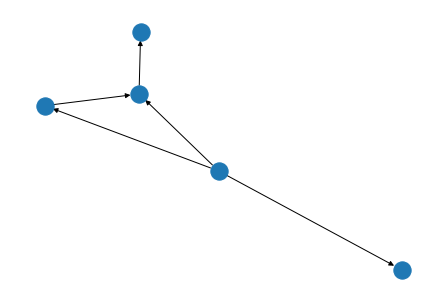

In [143]:
nx.draw(G)

In [34]:
G = nx.DiGraph()
G.add_edges_from(np.stack([in_edges, out_edges]).T)

In [18]:
len(G.edges())

32785

In [39]:
S = [G.subgraph(c).copy() for c in nx.weakly_connected_components(G)]

In [53]:
def get_valid_paths(subgraph):
    dag_subgraph = nx.dag_to_branching(subgraph)
    map_tuple = np.array(list(dag_subgraph.nodes(data="source")))
    source_dag_map = np.zeros(map_tuple[:, 0].max()+1, dtype=np.long)
    source_dag_map[map_tuple[:, 0]] = map_tuple[:, 1] 

    all_subgraph_paths = nx.shortest_path(dag_subgraph)
    all_subgraph_paths = {path: all_subgraph_paths[path] for path in all_subgraph_paths.keys() if source_dag_map[path] in starting_nodes}

    valid_paths = [source_dag_map[all_subgraph_paths[start_key][end_key]]
            for start_key in all_subgraph_paths.keys() 
            for end_key in all_subgraph_paths[start_key].keys() 
            if (start_key != end_key and source_dag_map[end_key] in ending_nodes)]

    return valid_paths

In [56]:
valid_paths = process_map(get_valid_paths, S, max_workers=8)

100%|██████████| 2847/2847 [01:26<00:00, 32.86it/s]


In [58]:
len(valid_paths)

2847

In [60]:
np.array(list(itertools.chain.from_iterable(valid_paths)))

NameError: name 'itertools' is not defined

In [156]:
branch_G = nx.dag_to_branching(G)

KeyboardInterrupt: 

In [21]:
nx.maximum_branching(G)

24624

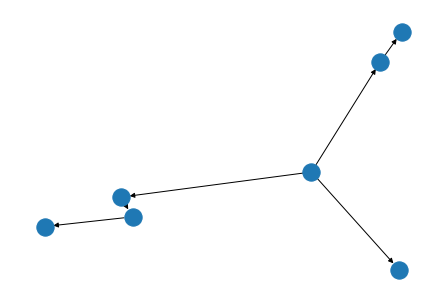

In [145]:
nx.draw(branch_G)

In [146]:
nx.shortest_path(branch_G)

{1: {1: [1],
  2: [1, 2],
  5: [1, 5],
  7: [1, 7],
  3: [1, 2, 3],
  6: [1, 5, 6],
  4: [1, 2, 3, 4]},
 2: {2: [2], 3: [2, 3], 4: [2, 3, 4]},
 3: {3: [3], 4: [3, 4]},
 4: {4: [4]},
 5: {5: [5], 6: [5, 6]},
 6: {6: [6]},
 7: {7: [7]}}

In [148]:
map_tuple = np.array(list(branch_G.nodes(data="source")))

In [149]:
map_tuple

array([[1, 0],
       [2, 1],
       [3, 2],
       [4, 3],
       [5, 2],
       [6, 3],
       [7, 8]])

In [151]:
source_dag_map = np.zeros(map_tuple[:, 0].max()+1, dtype=np.long)

In [152]:
source_dag_map[map_tuple[:, 0]] = map_tuple[:, 1] 

In [154]:
source_dag_map[map_tuple[:, 0]]

array([0, 1, 2, 3, 2, 3, 8])

In [65]:
all_paths = nx.all_simple_paths(G, 0, [2, 3])

In [66]:
list(all_paths)

[[0, 1, 2], [0, 2], [0, 3]]

In [49]:
nx.to_pandas_edgelist(nx.maximum_spanning_tree(G.to_undirected())).to_numpy().T

array([[0, 0, 0],
       [1, 2, 3]])

In [25]:
len(nx.shortest_path(nx.maximum_branching(G)))

24624

In [51]:
nx.to_pandas_edgelist(G).to_numpy()

array([[0, 1],
       [0, 2],
       [0, 3],
       [1, 2]])

In [52]:
nx.to_pandas_edgelist(nx.maximum_spanning_arborescence(G)).to_numpy()

array([[0, 1, 1],
       [0, 2, 1],
       [0, 3, 1]])

In [53]:
nx.to_pandas_edgelist(nx.minimum_spanning_arborescence(G)).to_numpy()

array([[0, 1, 1],
       [0, 2, 1],
       [0, 3, 1]])

In [23]:
nx.maximum_branching(G)

In [59]:
list(nx.maximum_spanning_edges(G.to_undirected()))

[(0, 1, {}), (0, 2, {}), (0, 3, {})]

In [61]:
list(nx.minimum_spanning_tree(G.to_undirected()))

[0, 1, 2, 3]

### Real Data

In [115]:
nx.to_pandas_edgelist(nx.maximum_spanning_tree(undirG)).to_numpy().T

array([[     6,      6,     80, ..., 282433, 282617, 282871],
       [    80,   1030,    126, ..., 286076, 286298, 286602]])

In [91]:
G = undirG.to_directed()

In [110]:
dir = nx.to_pandas_edgelist(G).to_numpy().T
undir = nx.to_pandas_edgelist(undirG).to_numpy().T

In [108]:
R[in_edges] < R[out_edges]

tensor([True, True, True,  ..., True, True, True])

In [111]:
(R[undir[0]] < R[undir[1]]).all()

tensor(False)

In [112]:
(R[dir[0]] < R[dir[1]]).all()

tensor(True)

In [92]:
all_paths = nx.shortest_path(G)

In [93]:
all_paths = {path: all_paths[path] for path in all_paths.keys() if path in starting_nodes}

In [94]:
valid_paths = [all_paths[start_key][end_key] for start_key in all_paths.keys() for end_key in all_paths[start_key].keys() if (start_key != end_key and end_key in ending_nodes)]

In [151]:
import itertools

In [157]:
# Flatten valid paths list 
np.array(list(itertools.chain.from_iterable(valid_paths)))


array([     6,     80,    126, ..., 286298, 282871, 286602])

In [155]:
np.repeat(np.arange(len(valid_paths)), [len(path) for path in valid_paths])

array([   0,    0,    0, ..., 3440, 3441, 3441])

In [147]:
np.repeat(np.arange(10), [2, 2, 2, 1, 1, 1, 1, 1, 1, 1])

array([0, 0, 1, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9])

In [79]:
from tqdm.contrib.concurrent import process_map, thread_map

In [114]:
def filter_paths(i):
    return [all_paths[start_key][end_key] for start_key in all_paths.keys() for end_key in all_paths[start_key].keys() if (start_key != end_key and end_key in ending_nodes)]

In [122]:
test_paths = process_map(filter_paths, range(100), max_workers=4)

100%|██████████| 100/100 [00:11<00:00,  8.96it/s]


In [124]:
test_paths = process_map(filter_paths, range(1000), max_workers=8)

100%|██████████| 1000/1000 [01:05<00:00, 15.33it/s]


### BFS Method

In [55]:
G = nx.DiGraph()
G.add_edges_from(np.stack([in_edges, out_edges]).T)

In [57]:
all_paths = list(nx.edge_bfs(G, starting_nodes))

### Longest Simple Paths Method

In [ ]:
from functools import partial
get_simple_path
partial_simple_paths = partial(nx.all_simple_paths, )

In [78]:
process_map

NameError: name 'process_map' is not defined

In [103]:
components = nx.weakly_connected_components(G)

In [102]:
for component in components:
    print(component)

{6, 1030, 1002, 80, 126}
{993, 8, 171, 1105, 151, 61, 1055}
{85922, 76130, 68868, 85926, 105639, 9, 68874, 85933, 18225, 106098, 18138, 90, 18271}
{98, 76323, 261, 18439, 170, 11, 56140, 56175, 18256, 76303, 148, 18388, 68917, 56152, 18331}
{131, 18309, 17, 1177, 19873, 1060, 172, 230966, 65, 56136, 1099, 19919, 18397, 106080, 19815, 69098, 1135, 76399, 18289, 234737, 243}
{16963, 49028, 69, 48966, 17109, 17014, 22, 17080, 18229, 49049, 48927}
{1034, 85898, 49, 113, 1074, 25, 187, 1017}
{85930, 16970, 17005, 109, 81, 85236, 27, 17051}
{32, 18408, 75, 18251, 55691, 18352, 85938, 123, 18300, 105597, 106079}
{16960, 105632, 68705, 132, 70, 39, 166, 105616, 76018, 48883, 228083, 231061, 18326, 18298, 18205}
{1028, 18150, 18214, 19725, 78, 46, 106111, 69039, 115, 1019, 18302, 19775}
{18464, 18275, 18404, 200, 233, 47, 18356, 149, 89}
{1249, 228, 19876, 18501, 202, 139, 1162, 1037, 18383, 1072, 1233, 50, 18325, 19963, 18457, 283, 19934}
{17088, 17026, 230, 17161, 17137, 119, 58, 159}
{67, 17

In [77]:
all_paths = [list(nx.all_simple_paths(G, starting_node, ending_nodes)) for starting_node in starting_nodes]

KeyboardInterrupt: 

In [114]:
roots = (v for v, d in G.in_degree() if d == 0)
leaves = [v for v, d in G.out_degree() if d == 0]

In [115]:
valid_path = []
for root in tqdm(roots):
    for leaf in leaves:
        valid_path.append((root, leaf)) if nx.has_path(G, root, leaf) else None

427it [00:20, 20.39it/s]


KeyboardInterrupt: 

In [111]:
all_paths = []
for root in tqdm(roots):
    paths = nx.all_simple_paths(G, root, leaves)
    all_paths.extend(paths)

143it [00:18,  7.67it/s]


KeyboardInterrupt: 

In [33]:
all_paths = []
for starting_node in tqdm(starting_nodes):
    all_paths.append(list(nx.all_simple_edge_paths(G, starting_node, ending_nodes)))

  5%|▍         | 146/3070 [00:38<12:58,  3.76it/s]


KeyboardInterrupt: 

In [ ]:
all_paths = [list(nx.all_simple_paths(G, starting_node, ending_nodes)) for starting_node in starting_nodes]

KeyboardInterrupt: 

## All Paths Building

In [5]:
tracking_data.build_candidates(building_method="AP", score_cut = 0.1, sanity_check=False)

INFO:root:Building candidates with sanity check: False
100%|██████████| 2/2 [00:11<00:00,  5.78s/it]


In [ ]:
tracking_data.build_candidates(building_method="AP", score_cut = 0.1, sanity_check=True)

INFO:root:Building candidates with sanity check: True
100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


In [6]:
matching_config = {
    "min_hits_truth": 3,
    "min_hits_reco": 3,
    "frac_reco_matched": 0.5,
    "frac_truth_matched": 0.5,
}

In [7]:
tracking_data.evaluate_candidates(evaluation_method="matching", **matching_config)

INFO:root:Evaluating candidates
100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

{'building_method': 'AP', 'evaluation_method': 'matching', 'eff': 0.7553503986571548, 'single_eff': 0.7620646244229963, 'fr': 0.2231581376564934, 'dup': 0.25062020423469683}
n_true_tracks: 2383, n_reco_tracks: 17333, n_matched_particles: 1800, n_matched_tracks: 13465, n_duplicated_tracks: 4344


In [8]:
particles = tracking_data[0].candidates.evaluation["particles"]

In [9]:
particles[particles.is_trackable & particles.is_fiducial]

,particle_id,is_fiducial,is_trackable,is_matched,is_double_matched
754,1147,True,True,True,True
806,1216,True,True,True,True
825,1240,True,True,True,True
827,1243,True,True,True,True
829,1249,True,True,True,True
...,...,...,...,...,...
78930,16400001043,True,True,True,True
78931,16400001047,True,True,True,True
78938,16400001059,True,True,True,True
78941,16400001065,True,True,False,False


In [10]:
candidates = tracking_data[0].candidates.evaluation["candidates"]

In [11]:
particles = tracking_data[0].event_truth.particles
truth = tracking_data[0].event_truth.hit_truth

In [12]:
particles[particles.particle_id == 16400001065]

,particle_id,subevent,barcode,px,py,pz,pt,eta,vx,vy,...,radius,status,charge,pdgId,pass,vProdNIn,vProdNOut,vProdStatus,vProdBarcode,is_fiducial
78941,16400001065,1640,1065,255.941,1446.4,1446.4,1468.87,3.96355,-0.005387,-0.010624,...,0.011911,1,1.0,211,YES,1,2,0,-676,True


In [13]:
truth[truth.particle_id == 16400001065]

,hit_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,hardware,cluster_x_1,cluster_y_1,...,phi_angle_1,norm_x,norm_y,norm_z_1,cluster_x_2,cluster_y_2,cluster_z_2,eta_angle_2,phi_angle_2,norm_z_2
145841,145400,7.08359,38.5477,1006.0,145400,-1,16400001065,PIXEL,7.08359,38.5477,...,0.982794,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
145944,145503,7.90474,42.8548,1121.0,145503,-1,16400001065,PIXEL,7.90474,42.8548,...,0.982794,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
145986,145545,8.84828,47.7004,1251.0,145545,-1,16400001065,PIXEL,8.84828,47.7004,...,0.982794,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
146051,145610,9.94514,53.1796,1398.0,145610,-1,16400001065,PIXEL,9.94514,53.1796,...,0.982794,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
146764,146323,7.12500,38.7000,1010.0,146323,-1,16400001065,PIXEL,7.12500,38.7000,...,0.982794,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
146806,146365,7.96667,43.0250,1125.0,146365,-1,16400001065,PIXEL,7.96667,43.0250,...,0.785398,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
146879,146436,8.87500,47.8500,1255.0,146436,-1,16400001065,PIXEL,8.87500,47.8500,...,0.982794,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
166991,166465,16.48990,85.6199,2270.0,166465,-1,16400001065,PIXEL,16.48990,85.6199,...,1.107150,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
167099,166572,18.14410,93.7044,2487.0,166572,-1,16400001065,PIXEL,18.14410,93.7044,...,1.107150,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
167160,166633,19.98140,102.6760,2728.0,166633,-1,16400001065,PIXEL,19.98140,102.6760,...,1.107150,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [15]:
candidates[candidates.hit_id == 145400]

,hit_id,track_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,hardware,cluster_x_1,...,status,charge,pdgId,pass,vProdNIn,vProdNOut,vProdStatus,vProdBarcode,is_fiducial,is_matched
44732,145400,7833,7.08359,38.5477,1006.0,145400.0,-1.0,1.640000e+10,PIXEL,7.08359,...,1.0,1.0,211.0,YES,1.0,2.0,0.0,-676.0,True,True


In [16]:
candidates[candidates.track_id == 25810]

,hit_id,track_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,hardware,cluster_x_1,...,status,charge,pdgId,pass,vProdNIn,vProdNOut,vProdStatus,vProdBarcode,is_fiducial,is_matched


In [ ]:
candidates[candidates.track_id == 25810]

,hit_id,track_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,hardware,cluster_x_1,...,status,charge,pdgId,pass,vProdNIn,vProdNOut,vProdStatus,vProdBarcode,is_fiducial,is_matched
156289,145400,25810,7.08359,38.5477,1006.0,145400.0,-1.0,1.640000e+10,PIXEL,7.08359,...,1.0,1.0,211.0,YES,1.0,2.0,0.0,-676.0,True,True
156290,145503,25810,7.90474,42.8548,1121.0,145503.0,-1.0,1.640000e+10,PIXEL,7.90474,...,1.0,1.0,211.0,YES,1.0,2.0,0.0,-676.0,True,True
156291,146436,25810,8.87500,47.8500,1255.0,146436.0,-1.0,1.640000e+10,PIXEL,8.87500,...,1.0,1.0,211.0,YES,1.0,2.0,0.0,-676.0,True,True


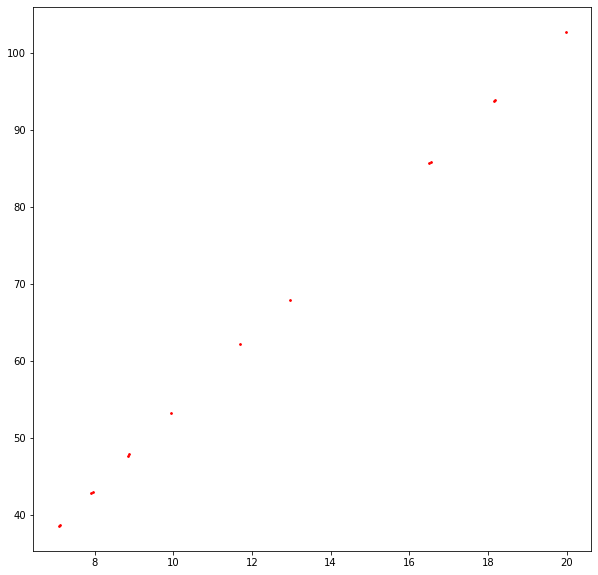

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(truth[truth.particle_id == 16400001065].x, truth[truth.particle_id == 16400001065].y, c="r", s=3)
plt.scatter(candidates[candidates.track_id == 12557].x, candidates[candidates.track_id == 12557].y, c="b", s=3)

In [18]:
graph = tracking_data[0].graph
edges = graph.edges["edge_index"]
scores = graph.edges["scores"]
hid = graph.hits["hid"]
pid = graph.hits["pid"]
y_true = graph.edges["y"]
true_edges = edges[:, y_true]
r, phi, z = graph.hits["x"].T
x, y = r * np.cos(phi), r * np.sin(phi)

In [19]:
passing_edges = edges[:, scores > 0.1]

In [20]:
passing_edges = hid[passing_edges[:, (pid[passing_edges] == 16400001065).any(0)]]

In [21]:
true_edges = hid[true_edges[:, (pid[true_edges] == 16400001065).any(0)]]

In [22]:
signal_edges = graph.graph_data["signal_true_edges"][:, (pid[graph.graph_data["signal_true_edges"]] == 16400001065).any(0)]

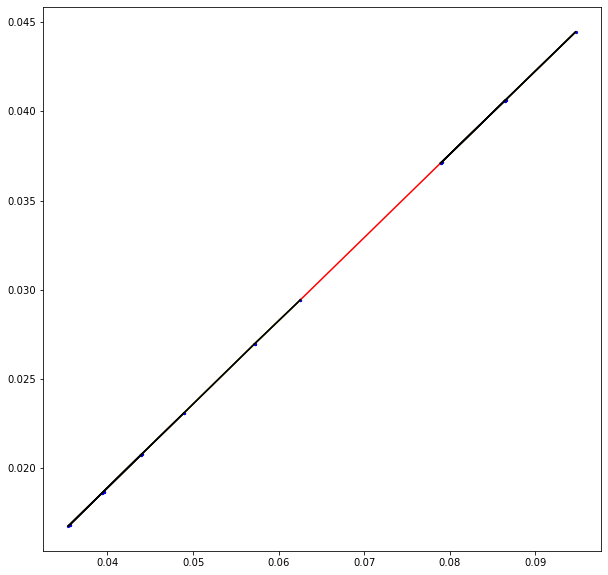

In [23]:
plt.figure(figsize=(10, 10));
plt.plot(x[signal_edges], y[signal_edges], "r");
plt.plot(x[true_edges], y[true_edges], "g");
plt.plot(x[passing_edges], y[passing_edges], "k");
plt.scatter(x[signal_edges], y[signal_edges], c="b", s=5);

In [24]:
passing_edges

tensor([[145400, 146323, 146365, 145503, 146365, 146436, 145610, 145545, 145610,
         146323, 146323, 146365, 146365, 146436, 166465, 167930, 168016, 166633,
         166572, 166572, 167930, 168016, 169266],
        [145503, 145400, 145400, 145545, 145503, 145503, 145545, 146436, 169179,
         145503, 146365, 145545, 146436, 145610, 166572, 166465, 166465, 166572,
         168016, 167930, 168016, 166633, 169179]])

In [25]:
signal_edges

tensor([[145400, 146323, 145503, 146365, 145545, 146436, 145610, 169179, 169266,
         166465, 167930, 166572, 168016],
        [146323, 145503, 146365, 145545, 146436, 145610, 169179, 169266, 166465,
         167930, 166572, 168016, 166633]])

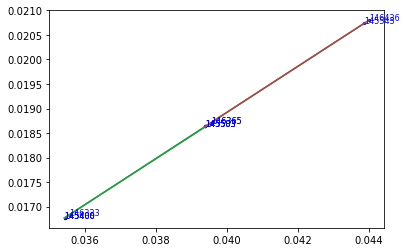

In [40]:
num_edges = 6
plt.plot(x[passing_edges[:, :num_edges]], y[passing_edges[:, :num_edges]]);
plt.scatter(x[passing_edges[:, :num_edges]], y[passing_edges[:, :num_edges]], c="b", s=5);
# Add index as text to plot
for i in range(num_edges):
    plt.text(x[passing_edges[0, i]].item(), y[passing_edges[0, i]].item(), passing_edges[0, i].item(), color="b", fontsize=8)
    plt.text(x[passing_edges[1, i]].item(), y[passing_edges[1, i]].item(), passing_edges[1, i].item(), color="b", fontsize=8)

In [41]:
passing_edges[:,  :num_edges]

tensor([[145400, 146323, 146365, 145503, 146365, 146436],
        [145503, 145400, 145400, 145545, 145503, 145503]])

In [42]:
signal_edges[:, :num_edges]

tensor([[145400, 146323, 145503, 146365, 145545, 146436],
        [146323, 145503, 146365, 145545, 146436, 145610]])

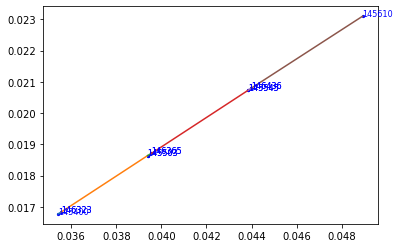

In [43]:
plt.plot(x[signal_edges[:, :num_edges]], y[signal_edges[:, :num_edges]]);
plt.scatter(x[signal_edges[:, :num_edges]], y[signal_edges[:, :num_edges]], c="b", s=5);
# Add index as text to plot
for i in range(num_edges):
    plt.text(x[signal_edges[0, i]].item(), y[signal_edges[0, i]].item(), signal_edges[0, i].item(), color="b", fontsize=8)
    plt.text(x[signal_edges[1, i]].item(), y[signal_edges[1, i]].item(), signal_edges[1, i].item(), color="b", fontsize=8)

In [171]:
graph.hits["modules"][true_edges[:, (pid[true_edges] == 16400001065).any(0)]].sort()

torch.return_types.sort(
values=tensor([[ 6713,  6713,  6929,  6929,  7142,  7145,  7358, 19460, 20105, 20318,
         20318, 20321],
        [ 6710,  6926,  6926,  7142,  7145,  7358, 19028, 19028, 20102, 20105,
         20321, 20534]]),
indices=tensor([[ 0,  4,  1,  5,  2,  6,  3, 11,  7,  8,  9, 10],
        [ 0,  1,  4,  5,  2,  6,  3, 11,  7,  9,  8, 10]]))

In [153]:
truth[truth.particle_id == 16400001065][["hit_id", "barrel_endcap", "hardware", "layer_disk", "eta_module", "phi_module"]]

,hit_id,barrel_endcap,hardware,layer_disk,eta_module,phi_module
145841,145400,2,PIXEL,0,13,4
145944,145503,2,PIXEL,0,14,4
145986,145545,2,PIXEL,0,15,4
146051,145610,2,PIXEL,0,16,4
146764,146323,2,PIXEL,0,13,5
146806,146365,2,PIXEL,0,14,5
146879,146436,2,PIXEL,0,15,5
166991,166465,2,PIXEL,1,27,4
167099,166572,2,PIXEL,1,28,4
167160,166633,2,PIXEL,1,29,4


In [102]:
edges = edges[:, scores > 0.5]

In [112]:
hit_mask = (hid[edges] == 169266).any(dim=0)

In [116]:
hid[edges[:, hit_mask]]

tensor([[169266],
        [169179]])

In [117]:
scores[hit_mask]

tensor([0.4203])

In [119]:
graph.edges["y"][hit_mask]

tensor([True])

In [123]:
particles = particles[particles.is_fiducial].merge(tracking_data[0].candidates.evaluation["particles"], on="particle_id")

## Plots

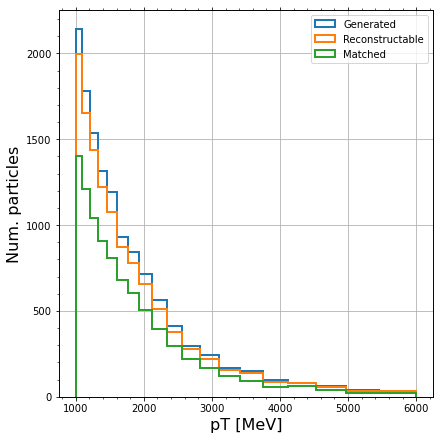

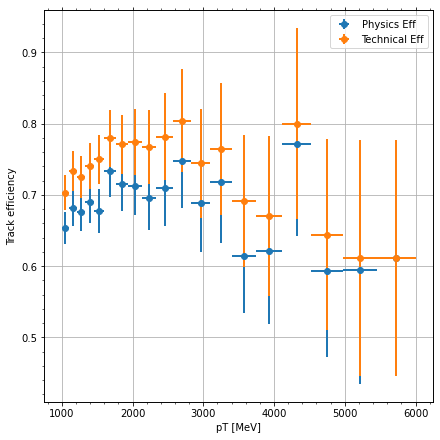

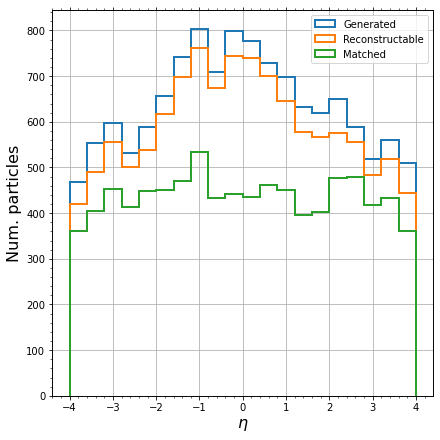

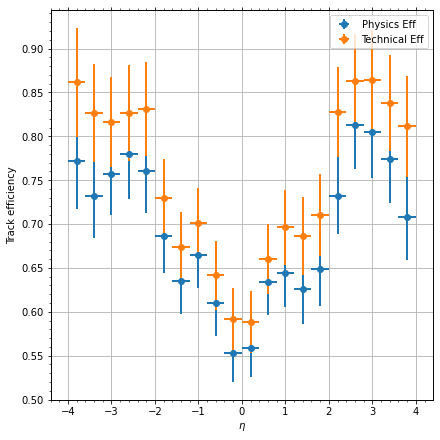

In [41]:
tracking_data.plot_evaluation()

In [14]:
tracking_data[0].event_truth.hit_truth

,hit_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,hardware,cluster_x_1,cluster_y_1,...,phi_angle_1,norm_x,norm_y,norm_z_1,cluster_x_2,cluster_y_2,cluster_z_2,eta_angle_2,phi_angle_2,norm_z_2
0,0,-48.2613,-15.05020,-263.00,0,-1,14550000033,PIXEL,-48.2613,-15.05020,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
1,1,-53.5710,-13.59470,-263.00,1,-1,16300000987,PIXEL,-53.5710,-13.59470,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
2,2,-38.5103,-4.58297,-263.00,2,-1,0,PIXEL,-38.5103,-4.58297,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
3,3,-52.1110,-12.55960,-263.00,3,-1,0,PIXEL,-52.1110,-12.55960,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
4,4,-45.5552,-17.87730,-263.00,4,-1,0,PIXEL,-45.5552,-17.87730,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287959,286626,896.4170,-128.11900,2854.25,406990,406997,15050000173,STRIP,878.6620,-125.24100,...,0.006379,0.0,0.0,1.0,878.429,-126.863,2860.75,1.32464,0.006379,-1.0
287960,286627,898.4870,-128.45800,2854.25,406990,407001,0,STRIP,878.6620,-125.24100,...,0.006379,0.0,0.0,1.0,928.314,-132.368,2860.75,1.32464,0.006379,-1.0
287961,286628,901.3200,-106.77600,2854.25,406991,407002,15310000473,STRIP,931.1220,-110.91000,...,0.006379,0.0,0.0,1.0,931.278,-109.593,2860.75,1.11586,0.006380,-1.0
287962,286629,901.9050,-129.09600,2854.25,406994,407001,14610000680,STRIP,928.1680,-133.38800,...,0.006379,0.0,0.0,1.0,928.314,-132.368,2860.75,1.32464,0.006379,-1.0


In [15]:
tracking_data[0].event_truth.hit_truth.particle_id.value_counts(sort=False).reset_index().rename(
        columns={"index":"particle_id", "particle_id": "n_true_hits"})

,particle_id,n_true_hits
0,14550000033,7
1,16300000987,13
2,0,157790
3,15930000060,14
4,15830000840,23
...,...,...
14588,14800200020,1
14589,15990200045,1
14590,16190200034,1
14591,15710200112,1


In [17]:
truth = tracking_data[0].event_truth.hit_truth

In [22]:
module_ID = ["barrel_endcap", "hardware", "layer_disk", "eta_module", "phi_module"]
truth = truth[truth.particle_id > 0]